In [1]:
from coffea import hist
import math

%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import mplhep as hep
import numpy as np
import random
plt.style.use(hep.style.CMS)

import awkward as ak

from matplotlib import colors
POPTS={'norm':colors.LogNorm(vmin=1,vmax=200)}

In [2]:
from data import getData, repackage
ldmx_dict = getData(chunks=True, fnames="/Users/chloeg/Desktop/Work/Fermilab2021/HistData/kshort_pn_4GeV_Jun13_ntuple/*.root")

In [3]:
def extend_array(arr, new_attr, new_attr_name):
    members={n:arr[n] for n in arr.fields}
    members[new_attr_name] = new_attr
    return ak.zip(members)

def add_angle(arr,br=['px','py','pz','e'],name="theta"):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    arr = extend_array(arr, part.theta, name)
    return arr

def get_vector(arr):
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)

    part =  ak.zip({"x": arr.px,
                    "y": arr.py,
                    "z": arr.pz,
                    "t": arr.e,
                    },
                    with_name="LorentzVector")
    return part

def flat(x,axis=None): # for now must cast while waiting for coffea to catch up
    try:
        return ak.to_numpy(ak.flatten(x,axis=axis)) 
    except:
        return x

In [4]:
def track_smear(kinetic_energy, theta):
    # assume flat uncertainty on the energy (I think that is 6%)
    c_eres = random.gauss(1.,0.06); # flat 10% uncertainty for now
    # assume some uncertainty on the angle (I think that is 2%)
    c_hres = random.gauss(0.,0.02); # 1 degrees
    return (c_eres*kinetic_energy, abs(c_hres+theta))

def piecewise_smear(pz):
    c_eres_array = []
    for part in pz:
        for element in part:
            if element <= 50:
                c_eres = random.gauss(1,0.0404);
            elif element <= 100: 
                c_eres = random.gauss(1,0.0410);
            elif element <= 250: 
                c_eres = random.gauss(1,0.0415);
            elif element <= 500: 
                c_eres = random.gauss(1,0.0420);
            elif element <= 1000: 
                c_eres = random.gauss(1,0.0435);
            elif element <= 2000:  
                c_eres = random.gauss(1,0.0477);
            elif element <= 3000:  
                c_eres = random.gauss(1,0.0523);
            elif element <= 4000:  
                c_eres = random.gauss(1,0.0573);            
            else:    
                c_eres = random.gauss(1,0.06);
            c_eres_array=np.append(c_eres_array, [c_eres])
    return (c_eres_array)

In [5]:
hists = {}
hists["sim_pion_e1"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Kinetic Energy [MeV]", 80, 0, 2000), 
                            )  
hists["sim_pion_e2"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Kinetic Energy [MeV]", 80, 0, 2000), 
                            )  
hists["sim_pion_e3"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Kinetic Energy [MeV]", 80, 0, 2000), 
                            )
hists["sim_pion_e4"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Kinetic Energy [MeV]", 80, 0, 2000), 
                            )
hists["sim_pion_e5"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"$\pi^\pm$ Kinetic Energy [MeV]", 80, 0, 2000), 
                            )

hists["sim_pion_mass1"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Mass [MeV]", 80, 400, 600), 
                            )  
hists["sim_pion_mass2"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Mass [MeV]", 80, 400, 600), 
                            )  
hists["sim_pion_mass3"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Mass [MeV]", 80, 400, 600), 
                            ) 
hists["sim_pion_mass4"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Mass [MeV]", 80, 400, 600), 
                            ) 
hists["sim_pion_mass5"] = hist.Hist("Sim Kaons",
                                hist.Bin("e", r"Reconstructed $K_s$ Mass [MeV]", 80, 400, 600), 
                            ) 
hists["sim_kaone_hist"] = hist.Hist("Sim Pions",     
                                hist.Bin("k", r"Reconstructed $K_s$ Kinetic Energy [MeV]", 40, 0, 3500),
                                hist.Bin("e", r"Electron Energy [MeV]", 40, 0, 1500),
                            )


In [6]:
def ProcessChunk(chunk, hists):
    ldmx_events = repackage(chunk)
    
    #constant definitions
    kshort_pdgid = 310
    chargedpion_pdgid = 211
    pion_mass = 139
    kaon_mass = 497.648
 
    #select events
    sim_kaon = ldmx_events['Sim_Kaon']
    sim_kaon_dau1 = ldmx_events['Sim_Kaon_dau1']
    sim_kaon_dau2 = ldmx_events['Sim_Kaon_dau2']
    
    #sim kaon masks
    k_mask = (abs(sim_kaon.pdgID)==kshort_pdgid)
    kshort_mask = (abs(sim_kaon_dau2.mompdgID)==kshort_pdgid)
        #same as kshort_pi_mask
    pidau_mask = (abs(sim_kaon_dau2.pdgID)==chargedpion_pdgid)

    #define vectors
    pi1 = get_vector(sim_kaon_dau1[pidau_mask & kshort_mask])
    pi2 = get_vector(sim_kaon_dau2[pidau_mask & kshort_mask])
    pisum = (pi1 + pi2)
    
    #define vector kinematics
    new_pz1 = piecewise_smear(pi1.pz)*flat(pi1.pz)
    new_psq1 = flat(pi1.px)**2+flat(pi1.py)**2+new_pz1**2
    new_pz2 = piecewise_smear(pi2.pz)*flat(pi2.pz)
    new_psq2 = flat(pi2.px)**2+flat(pi2.py)**2+new_pz2**2
    
    #theta masks
    theta_mask1 = ((40*math.pi/180) >= (flat(pi2.theta)))
    theta_mask2 = ((40*math.pi/180) >= (pi2.theta))
    
    #create smeared events
    from coffea.nanoevents.methods import vector
    ak.behavior.update(vector.behavior)
    pi1_track_smeared =  ak.zip({"x": flat(pi1.px),
                    "y": flat(pi1.py),
                    "z": new_pz1,
                    "t": (np.sqrt(new_psq1+flat(pi1.mass)**2)),
                    },
                    with_name="LorentzVector")
    pi2_track_smeared =  ak.zip({"x": flat(pi2.px),
                    "y": flat(pi2.py),
                    "z": new_pz2,
                    "t": (np.sqrt(new_psq2+flat(pi2.mass)**2)),
                    },
                    with_name="LorentzVector")
    pisum_track_smeared =(pi1_track_smeared+pi2_track_smeared)
    pisum_smeared_e_append = np.append(flat(pi1_track_smeared[theta_mask1].t), flat(pi2_track_smeared[theta_mask1].t))
    
    #percent masks for larger than 40 degrees
    #mask_15 = (-4.0*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+2800) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)
    #mask_30 = (-4.0*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+2040) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)
    #mask_50 = (-4.0*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+1500) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)
    #mask_75 = (-4.0*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+960) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)
    
    #percent masks for less than 40 degrees  
    mask_15 = (-1.5*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+3500) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)
    mask_30 = (-1.5*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+2500) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)
    mask_50 = (-1.5*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+1900) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)
    mask_75 = (-1.5*flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].mome-kaon_mass)+1300) <= flat(sim_kaon_dau2[theta_mask2 & pidau_mask & kshort_mask].electrone)


    acceptance_d = flat(flat(pisum_track_smeared[theta_mask1][mask_50].mass).shape)
    acceptance_n = flat(flat(pisum_track_smeared[theta_mask1].mass).shape)
    acceptance = flat(acceptance_d / acceptance_n)
    
    #fill histograms
    hists["sim_kaone_hist"].fill(
                                 k = flat(pisum_track_smeared[theta_mask1].t) - kaon_mass,
                                 e = flat(sim_kaon_dau2[kshort_mask][theta_mask2].electrone),
                                )    
    
    hists["sim_pion_mass1"].fill(
                                 e=flat(pisum_track_smeared[theta_mask1].mass),
                                )
    hists["sim_pion_mass2"].fill(
                                 e=flat(pisum_track_smeared[theta_mask1][mask_15].mass),
                                )
    hists["sim_pion_mass3"].fill(
                                 e=flat(pisum_track_smeared[theta_mask1][mask_30].mass),
                                )
    hists["sim_pion_mass4"].fill(
                                 e=flat(pisum_track_smeared[theta_mask1][mask_50].mass),
                                )
    hists["sim_pion_mass5"].fill(
                                 e=flat(pisum_track_smeared[theta_mask1][mask_75].mass),
                                )
    hists["sim_pion_e1"].fill(
                                e=flat(pisum_smeared_e_append)-pion_mass,
                                ) 
    pisum_smeared_e_append_15 = np.append(flat(pi1_track_smeared[theta_mask1][mask_15].t), flat(pi2_track_smeared[theta_mask1][mask_15].t))
    hists["sim_pion_e2"].fill(
                                e=flat(pisum_smeared_e_append_15)-pion_mass,
                                ) 
    pisum_smeared_e_append_30 = np.append(flat(pi1_track_smeared[theta_mask1][mask_30].t), flat(pi2_track_smeared[theta_mask1][mask_30].t))
    hists["sim_pion_e3"].fill(
                                e=flat(pisum_smeared_e_append_30)-pion_mass,
                                ) 
    pisum_smeared_e_append_50 = np.append(flat(pi1_track_smeared[theta_mask1][mask_50].t), flat(pi2_track_smeared[theta_mask1][mask_50].t))
    hists["sim_pion_e4"].fill(
                                e=flat(pisum_smeared_e_append_50)-pion_mass,
                                ) 
    pisum_smeared_e_append_75 = np.append(flat(pi1_track_smeared[theta_mask1][mask_75].t), flat(pi2_track_smeared[theta_mask1][mask_75].t))
    hists["sim_pion_e5"].fill(
                                e=flat(pisum_smeared_e_append_75)-pion_mass,
                                ) 
    return acceptance

In [7]:
nchunk = 0
percent = 0
for chunk in ldmx_dict:
    nchunk += 1
    returna = ProcessChunk(chunk, hists)
    percent += 100*returna[0]
    print('process', nchunk) 
    print('percent', percent/nchunk)

process 1
percent 43.80165289256198
process 2
percent 47.64340070370673
process 3
percent 47.23845761199497
process 4
percent 49.08268936284238
process 5
percent 49.44159008676513
process 6
percent 49.53465840563761
process 7
percent 50.325773457420226
process 8
percent 50.45707012386655
process 9
percent 50.8127886195887
process 10
percent 51.37965790577798
process 11
percent 51.60996568509461
process 12
percent 51.40396279754362
process 13
percent 51.02606012620761
process 14
percent 50.916695081117744
process 15
percent 50.8555820757099
process 16
percent 51.08112605312088
process 17
percent 51.33883539552257
process 18
percent 51.12321271347376
process 19
percent 50.77626730750146
process 20
percent 50.69899240366485
process 21
percent 50.630693045507144
process 22
percent 50.64189758809573
process 23
percent 50.634692931056364
process 24
percent 51.091878344643305
process 25
percent 51.39054555319992
process 26
percent 51.606968564986424
process 27
percent 51.4937743454566
process

<Hist (e) instance at 0x13269d6d0>


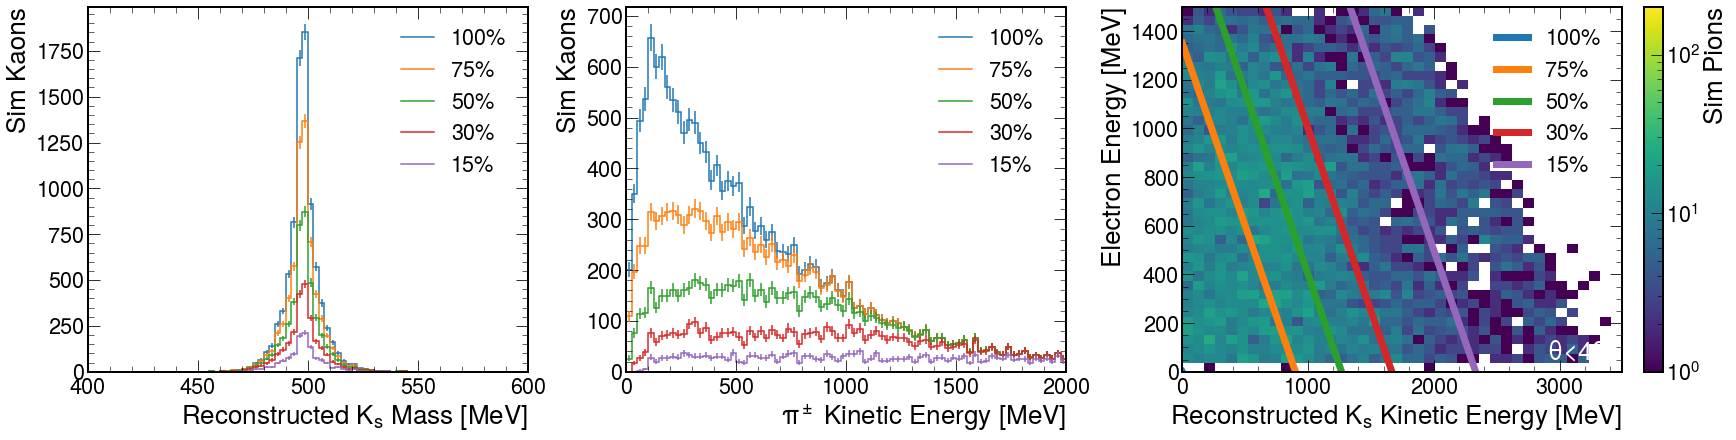

In [8]:
print(hists["sim_pion_mass1"])
fig, ax = plt.subplots(1,3,figsize=(24,6), constrained_layout=True)

 #this is 100% of the data with theta cut
hist.plot1d(hists["sim_pion_mass1"],ax=ax[0],clear=False);
hist.plot1d(hists["sim_pion_mass5"],ax=ax[0],clear=False);
hist.plot1d(hists["sim_pion_mass4"],ax=ax[0],clear=False);
hist.plot1d(hists["sim_pion_mass3"],ax=ax[0],clear=False);
hist.plot1d(hists["sim_pion_mass2"],ax=ax[0],clear=False);
leg = ax[0].legend([r'100%', r'75%', r'50%', r'30%', r'15%' ])


hist.plot1d(hists["sim_pion_e1"],ax=ax[1],clear=False);
hist.plot1d(hists["sim_pion_e5"],ax=ax[1],clear=False);
hist.plot1d(hists["sim_pion_e4"],ax=ax[1],clear=False);
hist.plot1d(hists["sim_pion_e3"],ax=ax[1],clear=False);
hist.plot1d(hists["sim_pion_e2"],ax=ax[1],clear=False);
leg = ax[1].legend([r'100%', r'75%', r'50%', r'30%', r'15%' ])



hist.plot2d(hists["sim_kaone_hist"], xaxis='k', ax=ax[2], patch_opts=POPTS);
#ax[2].text(2900, 50,r'$\theta$>40$^\circ$')
ax[2].text(2900, 50,r'$\theta$<40$^\circ$', color='white')

x = np.arange(0, 3250, 1)
lineouter = -1* x + 0
# for theta greater than 40
#line15 = -4.0* x + 2800
#line30 = -4.0* x + 2040
#line50 = -4.0* x + 1500
#line75 = -4.0* x + 960

# for theta less than 40
line15 = -1.5* x + 3500
line30 = -1.5* x + 2500
line50 = -1.5* x + 1900
line75 = -1.5* x + 1350

ax[2].plot(x, lineouter, '-', color='C0', linewidth=7.0)
ax[2].plot(x, line75, '-', color='C1', linewidth=7.0)
ax[2].plot(x, line50, '-', color='C2', linewidth=7.0)
ax[2].plot(x, line30, '-', color='C3', linewidth=7.0)
ax[2].plot(x, line15, '-', color='C4', linewidth=7.0)
leg = ax[2].legend([r'100%', r'75%', r'50%', r'30%', r'15%' ])
     

<Hist (k,e) instance at 0x10eed4340>


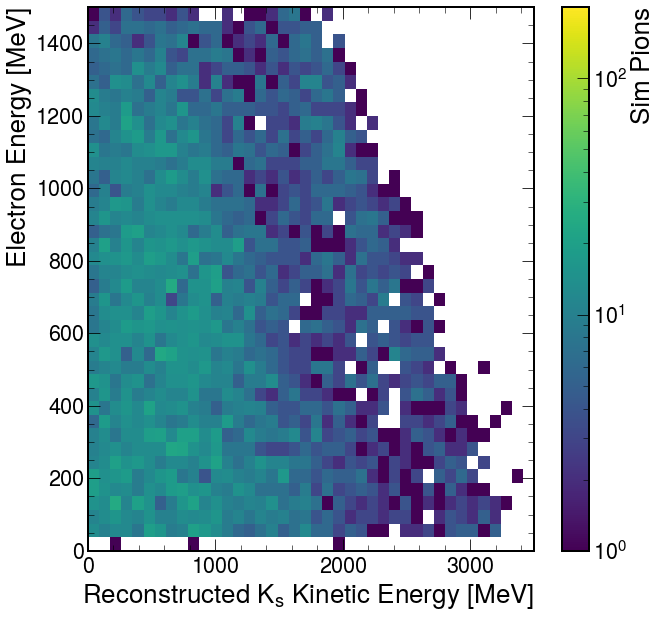

In [9]:
print(hists["sim_kaone_hist"])
fig, ax = plt.subplots()
hist.plot2d(hists["sim_kaone_hist"], xaxis='k', ax=ax, patch_opts=POPTS);